In [1]:
import numpy as np
import scipy.integrate as intgr
import scipy.sparse.linalg as la_efficient_solvers
import math as m
import matplotlib.pyplot as plt

Определение иерархии классов для численного интегрирования:

In [2]:
import numpy as np
class AbstractIntegral:
    _MethodName = 'Abstract Integral'
        
    def SetFunction(self, function):
        self._function = function
    
    def SetLeftBorder(self, leftBorder):
        self._leftBorder = leftBorder
        
    def SetNumBlocks(self, n):
        self._n = n
        
    def SetCoefficients(self, points):
        raise NotImplementedError
    
    def getName(self):
        return self._MethodName
    
    def __call__(self, x):
        self._gridArray = np.linspace(self._leftBorder, x, self._n + 1) 
        self._gridLength = len(self._gridArray)
        step = np.diff(self._gridArray)[0]
        
        self.SetCoefficients(self._gridLength)
        
        f, left, right, coeffs = self._function, self._leftBorder, x, self._coefficients    
        
        fValues = [f(t) for t in self._gridArray]
        value = np.dot(coeffs, fValues)#fValues)
        value *= step
        
        return value
    
        
class LeftRectangleIntegral(AbstractIntegral):
    
    def SetCoefficients(self, points):
        self._coefficients = [1] * (points - 1) + [0]

class RightRectangleIntegral(AbstractIntegral):
    
    def SetCoefficients(self, points):
        self._coefficients = [0] + [1] * (points - 1)

class MiddleRectangleIntegral(AbstractIntegral):
    
    def SetCoefficients(self, points):
        self._coefficients = [0.5] + [1] * (points - 2) + [0.5]

class TrapeziumIntegral(AbstractIntegral):
    
    def SetCoefficients(self, points):
        self._coefficients = [0.5] + [1] * (points - 2) + [0.5]
    
class SimpsonIntegral(AbstractIntegral):
    
    def SetCoefficients(self, points):
        self._coefficients = [1./3] + [4./3, 2./3] * ((points - 2) / 2)
        if (points % 2 == 1):
            self._coefficients += [4./3]
        self._coefficients += [1./3]

Проверка работы метода трапеций и сравнение интегрированием функцией из SciPy:

In [3]:
parabola = lambda t: t**2


INum = TrapeziumIntegral()
INum.SetFunction(parabola)
INum.SetLeftBorder(0.)
INum.SetNumBlocks(100)

# call
resultByOwn = INum(x=1.)
resultByScipy = intgr.quad(parabola, 0., 1.)

print(str(resultByOwn) + ' ' + str(resultByScipy[0]))

0.33335 0.33333333333333337


Определение функций-"шапочек" из МКЭ:

In [4]:
# a basis function is zero outside the corresponding finite element
class FEMesh:
    # equally-spaced nodes
    def __init__(self, xL, xR, numNodes):
        self._nodes = list(np.linspace(xL, xR, numNodes, dtype='float64'))
        self._finiteElems = [ [self._nodes[i], self._nodes[i + 1]] \
                             for i in range(len(self._nodes) - 1)] 
        self.h = float(np.diff(self._nodes)[0]) # equally-spaced nodes
    
    def __str__(self):
        counter = 0
        for elem in self._finiteElems:
            print('Elem #%d: [%.2f, %.2f]' % (counter, elem.xL, elem.xR))
            counter += 1
    

class BasisFunction:
    # the index "i" of a basis function: 1 <= i <= numNodes - 2
    
    def __init__(self, mesh, index):
        self._mesh = mesh
        self._i = index # "i" is a parameter
    
    def __call__(self, x):
        xArrayMesh = self._mesh._nodes # for short
        i = self._i # for short, too
        #print('Ha-ha %.2f' % xArrayMesh[0])
        
        # "hat" function
        if i != 0 and i != len(xArrayMesh) - 1:
            if x >= xArrayMesh[i - 1] and x < xArrayMesh[i]:
                return (x - xArrayMesh[i - 1]) / self._mesh.h
            elif x >= xArrayMesh[i] and x < xArrayMesh[i + 1]:
                return 1. - (x - xArrayMesh[i]) / self._mesh.h
            else:
                return 0.
            

        
        # left "half hat" function
        elif i == 0:
            if x >= xArrayMesh[0] and x < xArrayMesh[1]:
                return 1. - (x - xArrayMesh[i]) / self._mesh.h
            else: 
                return 0.
        
        # right "half-hat" function
        elif i == len(xArrayMesh) - 1:
            # be careful in choosing ">/<" or ">=/<=" signs! 
            if x > xArrayMesh[-2] and x <= xArrayMesh[-1]:
                return (x - xArrayMesh[-2]) / self._mesh.h
            else: 
                return 0.
    
    def Plot(self):
        xL = self._mesh._nodes[0]
        xR = self._mesh._nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self.__call__(x) for x in xData])
        #print(yData)
        
        plt.figure(figsize=(11, 6))
        plt.plot(xData, yData, 'b-', lw=10)
        plt.grid('on')
        plt.show()

In [5]:
# print(np.linspace(0., 1., 5)) --- just for test

0.25


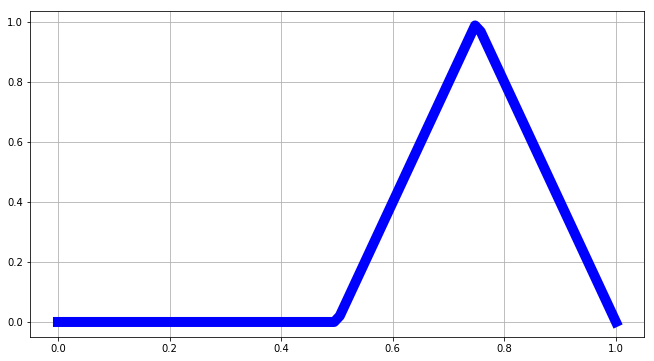

In [6]:
mesh1 = FEMesh(xL=0., xR=1., numNodes=5)
print(mesh1.h)

f = BasisFunction(mesh1, 3)
f.Plot()

## Решатели
Создаем иерархию "главных" классов - решателей. Абстрактный базовый класс:

In [7]:
class AbstractFemSolver:
    def __init__(self, mesh, function):
        self._mesh = mesh
        self._f = function
        self._numNodes = len(self._mesh._nodes)
        
        print('Number of nodes = %d' % self._numNodes, '\n')
        
        self._BasisFuncs = [BasisFunction(self._mesh, i) \
                            for i in range(0, self._numNodes)]
    
        
        
    def SetupLinearSystem(self):
        self._M = np.zeros((self._numNodes, self._numNodes))
        self._b = np.zeros(self._numNodes)
        
        for i in range(self._numNodes):
            # computing the mass matrix
            for j in range(self._numNodes):
                self._M[i, j] = self.MassMatrix(i, j)
    
            # computing the load vector
            self._b[i] = self.LoadVector(i)
        
    
    def MassMatrix(self, i, j):
        raise NotImplementedError()
        
    def LoadVector(self, i):
        raise NotImplementedError()
        
    
    def Solve(self):
        self.SetupLinearSystem()
        # self._c = np.linalg.solve(self._M, self._b) # метод LU-разложения
        # использование метода сопряженных градиентов как самого эффективного решателя СЛАУ
        # в данном контексте
        # [0] --- тут хранится вектор численного решения СЛАУ {c_j}
        self._c = la_efficient_solvers.cg(self._M, self._b)[0]
        
        
        
        # FOR DEBUG
        #print(self._M)
        #print(self._b, '\n')
        #print('The coeffs are:', self._c)
        
    
    

    def EvaluateSolution(self, x):
        value = 0.
        for coeff, BasisFunc in zip(self._c, self._BasisFuncs):
            value += coeff*BasisFunc(x)
        return value
    
    def PlotSolution(self):
        xL = self._mesh._nodes[0]
        xR = self._mesh._nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self.EvaluateSolution(x) for x in xData])
        #print(yData)
        
        plt.figure(figsize=(11, 7))
        plt.plot(xData, yData, '-', lw=2, label=self.__class__.__name__)
        plt.legend()
        plt.grid('on')
        plt.show()

Классы-наследники, отвечающие за:
1. Метод наименьших квадратов (эквивалентен L2-проекции)
2. Интерполяцию
3. Регрессию

In [8]:
class FEMSolverLeastSquares(AbstractFemSolver):
    
    def MassMatrix(self, i, j):
        integrationMethod = TrapeziumIntegral()
        integrationMethod.SetLeftBorder(self._mesh._nodes[0])
        integrationMethod.SetNumBlocks(int(1e2))
        integrationMethod.SetFunction(\
                            lambda t: self._BasisFuncs[i](t)*self._BasisFuncs[j](t) \
                                    )
        return integrationMethod(self._mesh._nodes[-1])
    
    def LoadVector(self, i):
        integrationMethod = TrapeziumIntegral()
        integrationMethod.SetLeftBorder(self._mesh._nodes[0])
        integrationMethod.SetNumBlocks(int(1e2))
        integrationMethod.SetFunction(lambda t: self._f(t)*self._BasisFuncs[i](t))
        
        return integrationMethod(self._mesh._nodes[-1])

In [9]:
class FEMSolverInterpolation(AbstractFemSolver):
        
    def __init__(self, mesh, function, interpolationPoints):
        AbstractFemSolver.__init__(self, mesh, function)
        self._interpolationPoints = interpolationPoints
        
        
    def MassMatrix(self, i, j):
        return self._BasisFuncs[j](self._interpolationPoints[i])
    
    def LoadVector(self, i):
        return self._f(self._interpolationPoints[i])

In [10]:
# тестирование
testFunc = lambda t: 1. + (t**2)*np.sin(2.*3.14*t)

Number of nodes = 6 



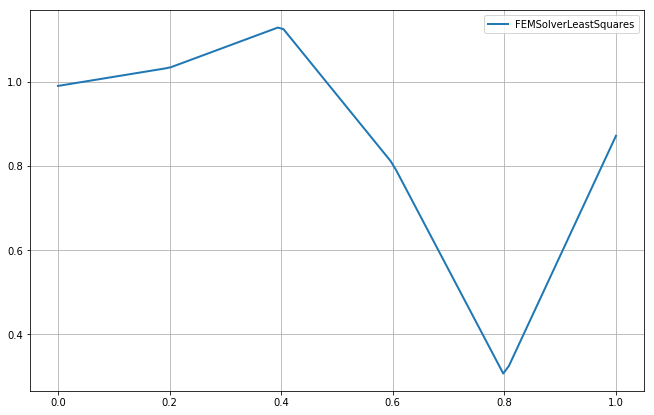

In [11]:
# тестирование
mesh2 = FEMesh(xL=0., xR=1., numNodes=6)

solver1 = FEMSolverLeastSquares(mesh2, testFunc)
solver1.Solve()
#plt.figure(figsize=(11, 7))
solver1.PlotSolution()
#plt.show()

Number of nodes = 6 



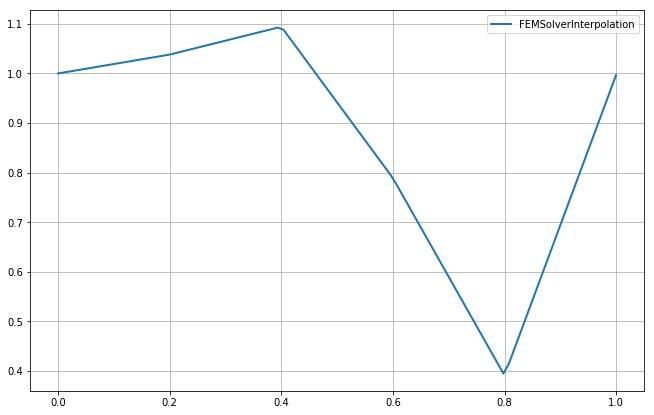

In [12]:
# тестирование
mesh3 = FEMesh(xL=0., xR=1., numNodes=6)
interpolationPoints1 = np.linspace(0., 1., 6)

#interpolationPoints1 = [0.02, 0.06,  0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 0.91]

#print(np.linspace(0., 1., 10))


solver2 = FEMSolverInterpolation(mesh2, testFunc, interpolationPoints1)  #np.linspace(0., 1., 10))
solver2.Solve()
solver2.PlotSolution()

### Метод регрессии

In [13]:
class FEMSolverRegression(AbstractFemSolver):
        
    def __init__(self, mesh, function, regressionPoints):
        AbstractFemSolver.__init__(self, mesh, function)
        self._regressionPoints = regressionPoints
        self._numRegressionPoints = len(self._regressionPoints)
    
    
    def MassMatrix(self, i, j):
        
        points = self._regressionPoints
        value = 0.
        for k in range(len(points)):
            value += self._BasisFuncs[i](points[k])*self._BasisFuncs[j](points[k])
        
        #self._M = self._MAux.transpose().dot(self._MAux)
        # for DEBUG
        # print(self._M, '\n')
        
        return value
    
    
    def LoadVector(self, i):
        
        points = self._regressionPoints
        value = 0.
        for k in range(len(points)):
            value += self._BasisFuncs[i](points[k])*self._f(points[k])
        
        #self._b = self._MAux.transpose().dot(self._bAux)
        # for DEBUG
        #print(self._b)
        
        return value

Number of nodes = 6 



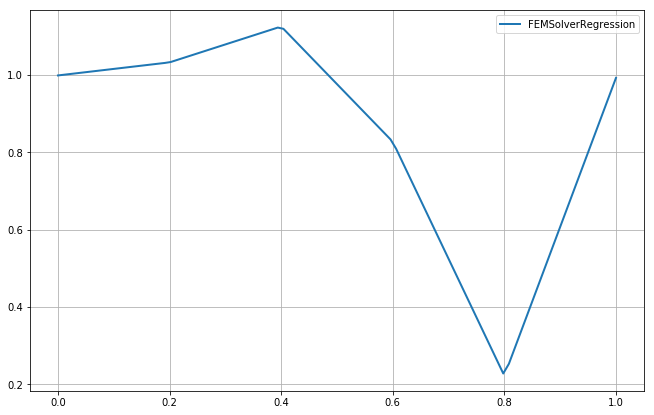

In [14]:
# тестирование
#mesh3 = FEMesh(xL=0., xR=1., numNodes=50)
# interpolationPoints1 = [0.02, 0.06,  0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 0.91]
regressionPoints1 = np.linspace(0., 1., 8)

#print(np.linspace(0., 1., 10))


solver3 = FEMSolverRegression(mesh2, testFunc, regressionPoints1)  #np.linspace(0., 1., 10))
solver3.Solve()
solver3.PlotSolution()

### Сравнение численных решений, получен. при различном кол-ве точек регрессии

Number of nodes = 6 



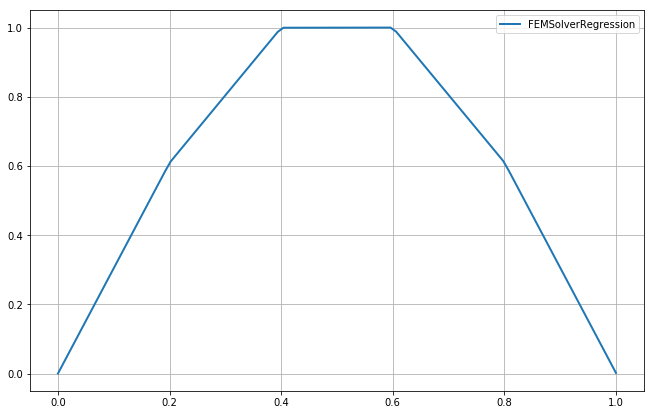

Number of nodes = 6 



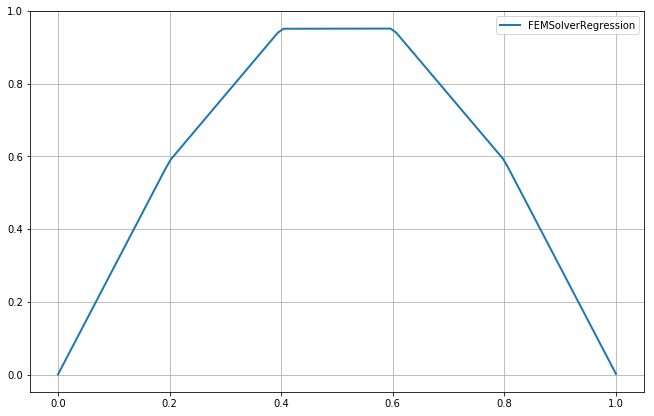

Number of nodes = 6 



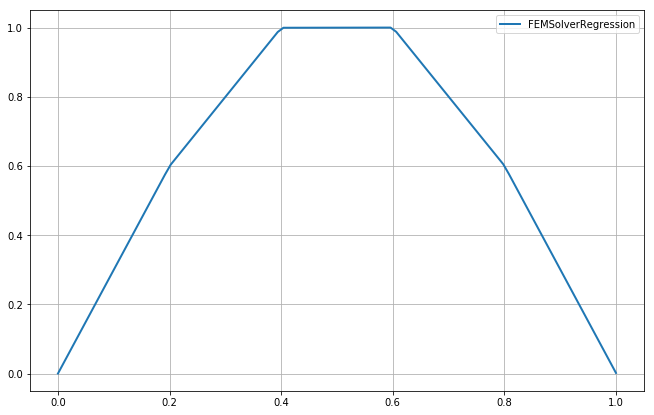

Number of nodes = 6 



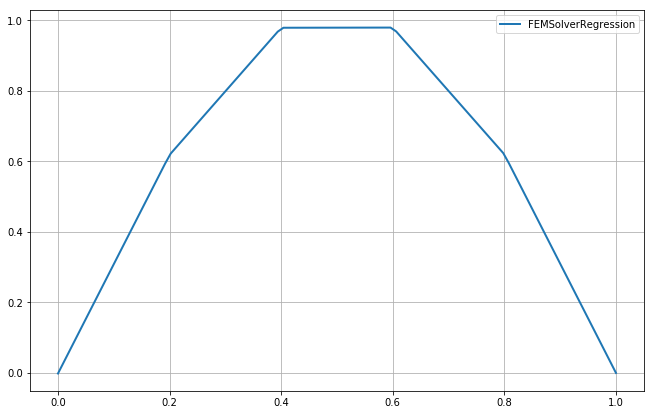

Number of nodes = 6 



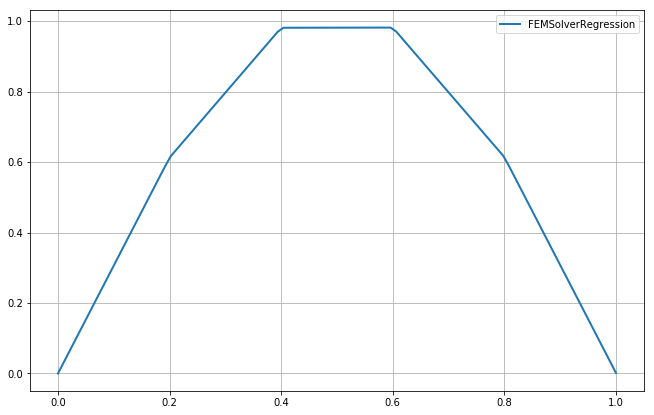

Number of nodes = 6 



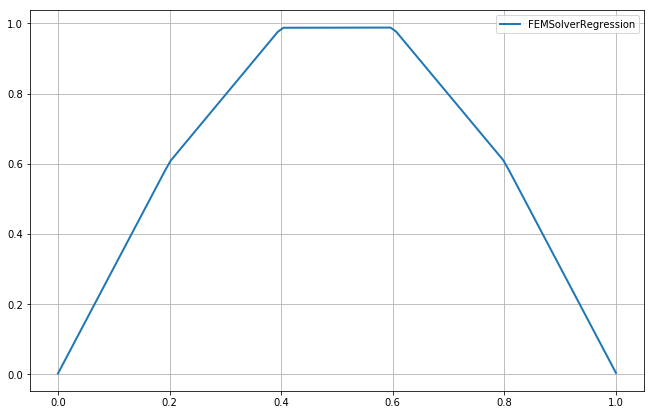

Number of nodes = 6 



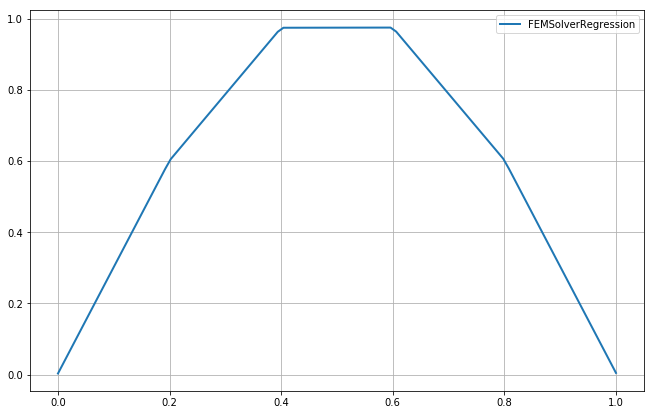

Number of nodes = 6 



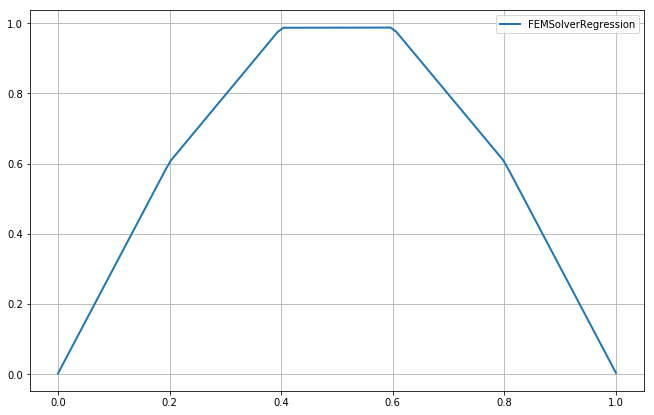

Number of nodes = 6 



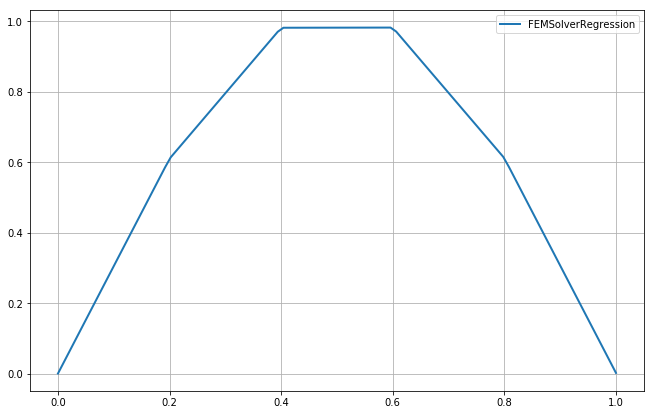

Number of nodes = 6 



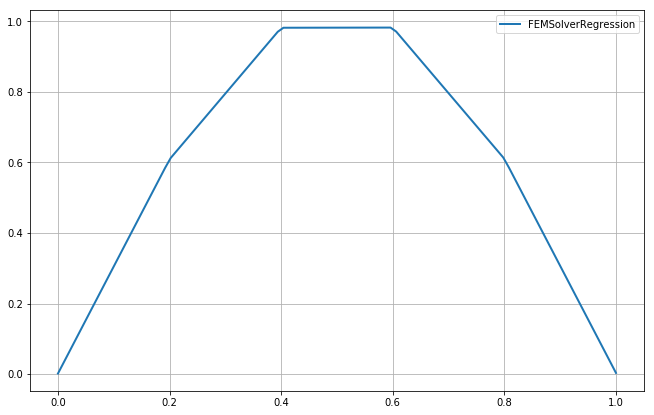

Number of nodes = 6 



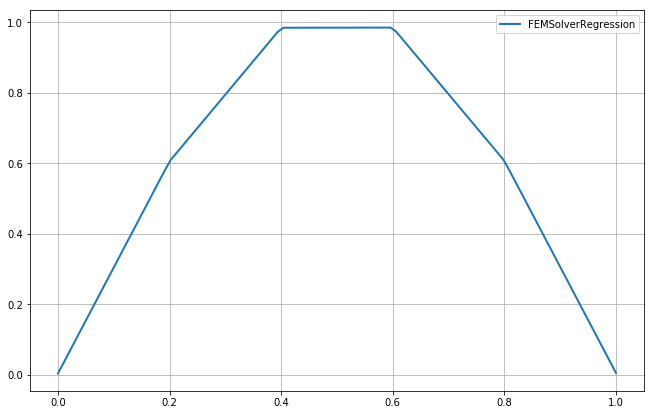

Number of nodes = 6 



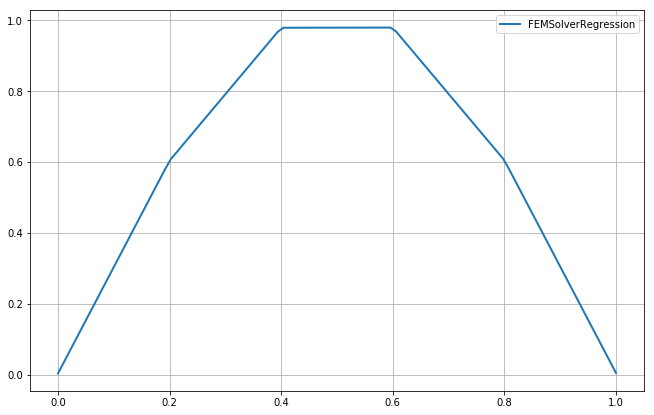

Number of nodes = 6 



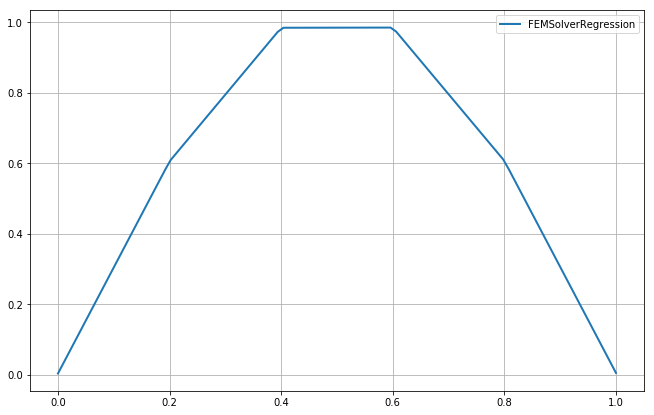

Number of nodes = 6 



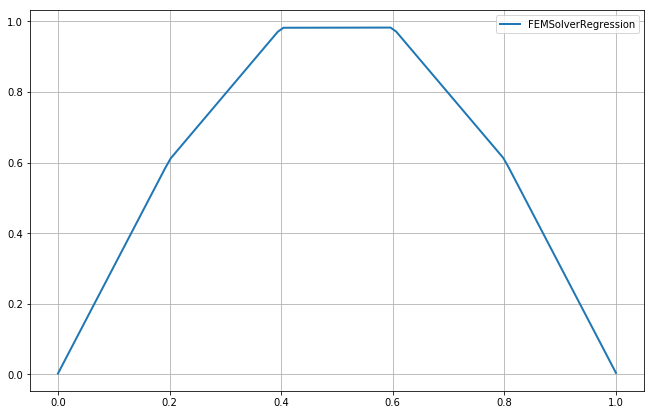

Number of nodes = 6 



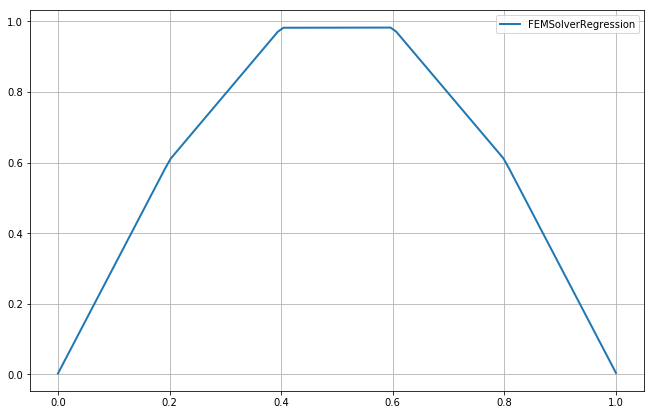

In [15]:

plt.figure(figsize=(11, 7))
for nPointsRegression in range(5, 20):

    regressionPoints = np.linspace(0., 1., nPointsRegression)
    solver4 = FEMSolverRegression(mesh3, lambda t: np.sin(3.14*t), regressionPoints)  #np.linspace(0., 1., 10))
    solver4.Solve()
    solver4.PlotSolution()
    
plt.show()

### Сравнение различных методов

Number of nodes = 6 

Number of nodes = 6 

Number of nodes = 6 



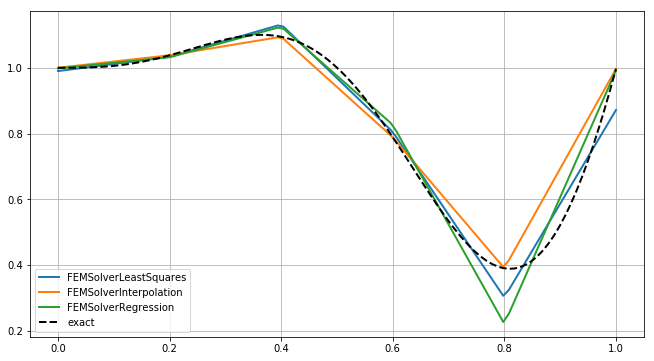

In [17]:
regressionPoints = np.linspace(0., 1., 8)
interpolPoints = mesh2._nodes
solvers = [FEMSolverLeastSquares(mesh3, testFunc), FEMSolverInterpolation(mesh3, testFunc, interpolPoints), \
               FEMSolverRegression(mesh3, testFunc, regressionPoints)]

plt.figure(figsize=(11, 6))
for solver in solvers:
    solver.Solve()
    

# plotting exact test function
xData = np.linspace(0., 1., 100)
for solver in solvers:
      plt.plot(xData, [solver.EvaluateSolution(x) for x in xData], '-', \
               label=solver.__class__.__name__, lw=2)

plt.plot(xData, testFunc(xData), 'k--', label='exact', lw=2)
plt.grid('on')
plt.legend()
plt.show()